In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn

# special matplotlib command for global plot configuration
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'

# Section 7: Classification with Decision Trees, Random Forests, and Cross Validation

### Last time
- PCA

### Today
- Decision Trees (with bagging)
- Random Forests
- Cross validation

## Note - this notebook works best in python 2.7 because pydot is currently only supported for python 2.7

## Splitting data into training and testing

For this problem we'll use the included iris dataset and use cross validation to help select the parameters for our decision tree classifier.  The [decision tree classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) is part of the sklearn library.  

In [2]:
#load the iris data set
from sklearn import datasets
iris = datasets.load_iris()

X = iris.data  
Y = iris.target

print(X.shape, Y.shape)

((150, 4), (150,))


Split the data into a train and a test set. Use a random selection of 33% of the samples as test data. Sklearn provides the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) function for this purpose. Print the dimensions of all the train and test data sets you have created. 

In [3]:
# put test data aside
from sklearn import cross_validation
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(
    X, Y, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(100, 4)
(50, 4)
(100,)
(50,)


### PCA to help visualize the groups...

We can examine the data a little further by looking at the projections to the first two principal components of the data.  To do this we'll use Principal Component Analysis [(PCA)](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and create a scatter plot of the result.  We can then color the data according to the type of iris. 

In [4]:
from sklearn import decomposition

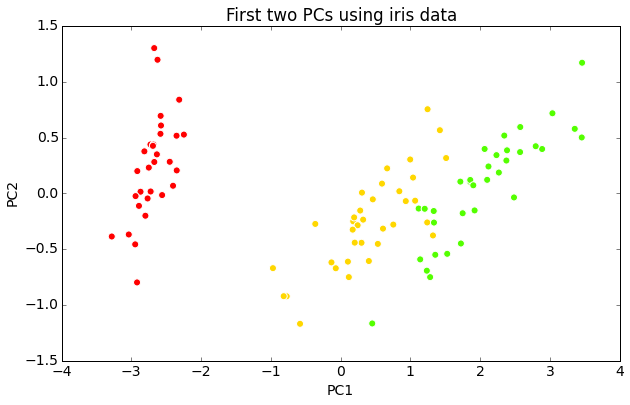

In [5]:
# make a scatter plot of the data in two dimensions
svd = decomposition.PCA(n_components=2)
X_train_centered = X_train - np.mean(X_train, axis=0)
X_2d = svd.fit_transform(X_train_centered)

plt.scatter(X_2d[:,0], X_2d[:,1], c=Y_train, s = 50, cmap=plt.cm.prism)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs using iris data')
plt.show()

## Decision Trees

What is the best depth for a decision tree on the four features provided by the iris dataset?

We'll use the [Decision Tree Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) from sklearn to model the iris dataset.  Decision tress are widely used classifiers because:
- they're simple to understand an interpret
- require little data prep
- processing cost is on the lower end of most classifiers (depends on size of dataset)
- handles both numerical and categorical data
- handles multi-output problems
- validation can be accomplished with [statistical tests](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.score)

Drawbacks of Decision Trees though include:
- can overfit the data and create overly complex trees
- unstable from noisy (or complex) data
- unbalanced dataset classes will create biased trees (we'll see this later...)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score

scores = []

for n in range(1,5):
    # create a model with training data 
    clf = DecisionTreeClassifier(max_depth=n).fit(X_train, Y_train)
    # now score it on the test data set
    scores.append(clf.score(X_test, Y_test))

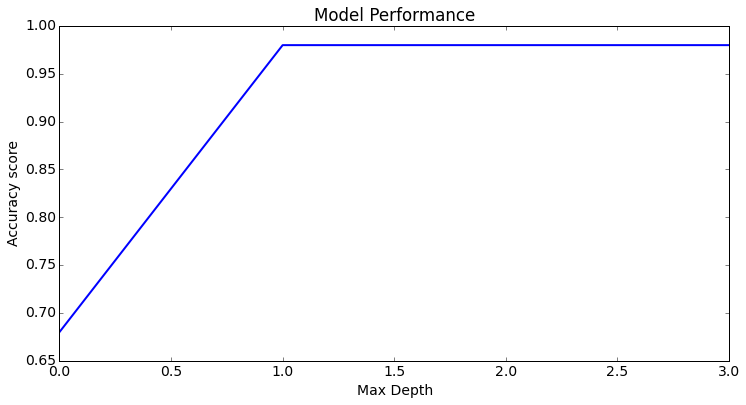

In [8]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,6)

plt.plot(scores)

plt.title('Model Performance')
plt.ylabel('Accuracy score')
plt.xlabel('Max Depth')
plt.show()

### Tree visualization

Requires the python library [pydot](https://pypi.python.org/pypi/pydot) and an OS package [graphviz](http://www.graphviz.org)

In [9]:
from sklearn import tree

In [10]:
with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

In [11]:
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("tree.pdf")

True

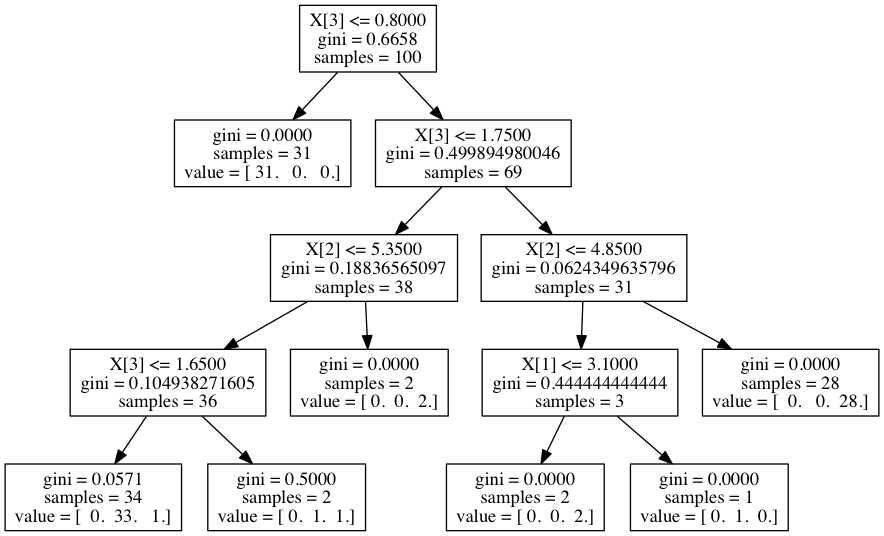

In [12]:
from IPython.display import Image #needed to render in notebook
Image(graph.create_png())

### Cross validation provides a method to evaluate our model performance

There are a number of features that can be tuned when we build models and the data can be sliced and used in inumerable ways.  How then to measure performance of or compare different models?  Use [cross validation](http://scikit-learn.org/stable/modules/cross_validation.html) to help since it automatically does the data splits into traning and testing for us. 

In [13]:
scores = []

for n in range(1,10):
    # create a model and fit it to the training data
    clf = DecisionTreeClassifier(max_depth=n)
    # now score it on the test data set
    scores.append(cross_val_score(clf, X, Y, cv=10))

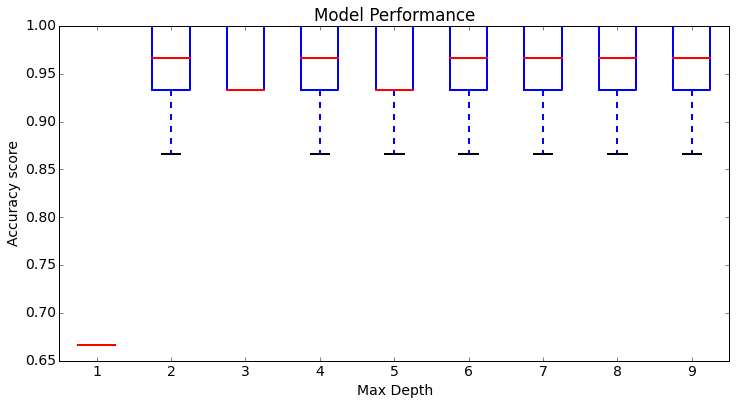

In [14]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,6)

plt.boxplot(scores)

plt.title('Model Performance')
plt.ylabel('Accuracy score')
plt.xlabel('Max Depth')
plt.show()

## Decision Tree Surface

This example is borrowed from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html)

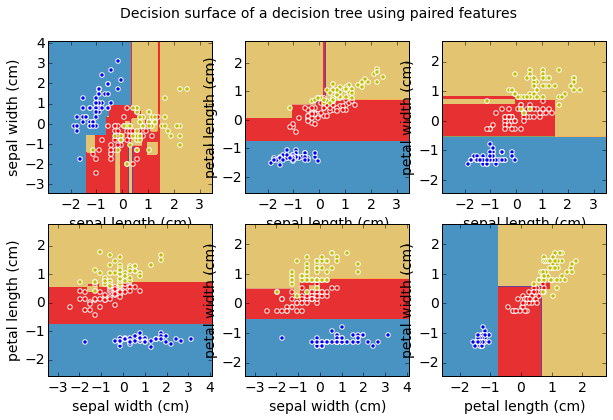

In [15]:
# Parameters
n_classes = 3
plot_colors = "bry"
plot_step = 0.02

# Load data
iris = datasets.load_iris()

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Shuffle
    idx = np.arange(X.shape[0])
    np.random.seed(13)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    # Standardize
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.Paired)

#     plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
# plt.legend()
plt.show()

## Random Forests

Switch datasets to examine the wine quality dataset hosted on the <a href="https://archive.ics.uci.edu/ml/datasets/Wine+Quality">UCI website</a>. This data records 11 chemical properties (such as the concentrations of sugar, citric acid, alcohol, pH etc.) of thousands of red and white wines from northern Portugal, as well as the quality of the wines, recorded on a scale from 1 to 10. We'll only look at the data for *red* wine.

First we need to load the dataset and do some prepartory work. 

In [16]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


Change the target from a score to a simple 'good' or 'bad' represented by a 1 or 0 and prepare the features dataset

In [17]:
Y = df['quality'].values
df = df.drop('quality',1)
Y = np.array([1 if y>=7 else 0 for y in Y])
X = df.as_matrix()

The random forest adds randomness in two ways. First, it randomly resamples the data with replacement, so each decision tree is being fit on a slightly different set of data. Secondly, for each split in each decision tree, the random forests algorithm only considers a random subset of variables to split on. All trees are trained independently of each other. To make predictions, all trees are queried independently and the majority vote wins.

post link to random forest

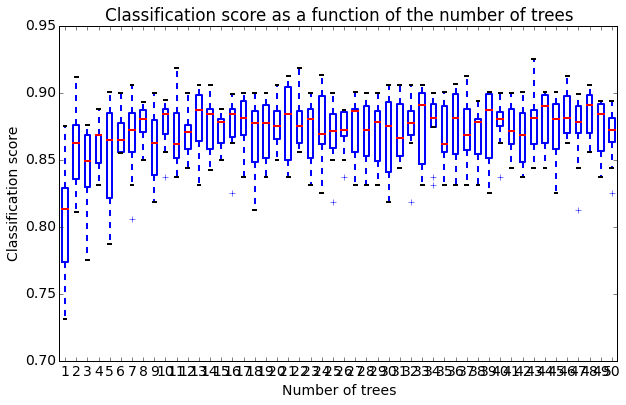

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

scores = []

for ne in range(1,51):
    clf = RandomForestClassifier(n_estimators = ne)
    score_list = cross_val_score(clf, X, Y, cv=10)
    scores.append(score_list)

plt.boxplot(scores)
plt.xlabel('Number of trees')
plt.ylabel('Classification score')
plt.title('Classification score as a function of the number of trees')
plt.show()

What trend can you see in the results? Do you think there could be any issues with this dataset and using a Random Forest classification?  What if we just flipped a coin to try and classify wine as good or bad?

86.4290181363


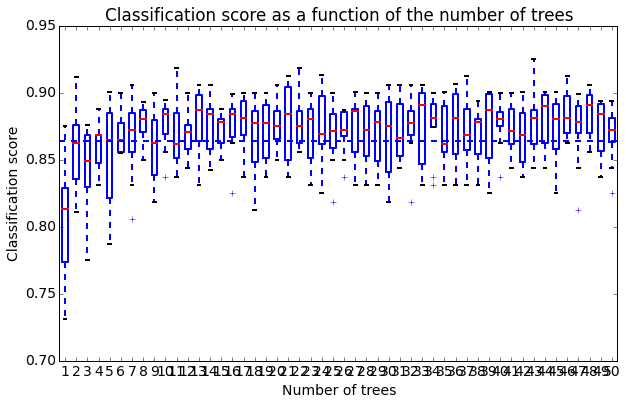

In [20]:
blind_guess_score = sum(1-Y)/float(len(Y))
print 100*float(sum(1-Y))/len(Y)

plt.boxplot(scores)
plt.axhline(y=blind_guess_score,ls='--')
plt.xlabel('Number of trees')
plt.ylabel('Classification score')
plt.title('Classification score as a function of the number of trees')
plt.show()

###Evaluation Metrics

When there are unbalanced classes in a dataset, guessing the more common class will often yield very high accuracy. For this reason, we usually want to use different metrics that are less sensitive to imbalance when evaluating the predictive performance of classifiers. These metrics were originally developed for clinical trials, so to keep with the standard terminology, we define "good" wines (value of 1) as "positive" and the "bad" wines (value of 0) as the "negatives". We then define the following:

$P$ - number of true positives in the sample.

$N$ - number of true negatives in the sample.

$TP$ - number of true positives: how many of the "positive" guesses of the classifier are true.

$FP$ - number of false positives: how many of the "positive" guesses of the classifier are actually negatives.

$TN$ - number of true negatives; similarly, this is how many of the "negative" guesses of the classifier are true.

$FN$ - number of false negatives; how many of the "negative" guesses are actually positives.

When calling the score functions in scikit-learn you obtained the default measure of efficiency, which is called **accuracy**. This is simply the ratio of successful guesses (both positives and negatives) across all samples:
$$\text{accuracy} = \frac{TP + TN}{P+N}.$$
In our case, when the two classes (good and bad wines) are very unbalanced in the sample, we should look for a better measure of efficiency. 

Usually, the goal is to identify the members of the positive class (the rare class) successfully -- this could be either the good wines or the patients presenting a rare disease. It is common practice to define the following ratios:

The **recall** rate (also called the sensitivity or the true positive rate) is the ratio of true positive guesses among all positives:
$$\text{recall} = \frac{TP}{P}=\frac{TP}{TP+FN}.$$
The **precision** is the ratio of the true positive guesses over all the positive guesses:
$$\text{precision} = \frac{TP}{TP+FP}.$$

### Recall and Precision Examples

Recall example: airport security screening, where you want a strategy that pulls aside all malicious passengers, even if it means that you also end up pulling aside many innocent people.

Precision example: when selecting job applicants for on-site interviews (which take a lot of time) you want to make sure that every selected applicant is good, and you don't care as much about interviewing every good applicant.

### F1 score

Because precision and recall both provide valuable information about the quality of a classifier, we often want to combine them into a single general-purpose score. The **F1** score is defined as the harmonic mean of recall and precision:
$$F_1 = \frac{2\times\text{recall}\times\text{precision}}{\text{recall} + \text{precision}}.$$

The harmonic mean of two numbers is closer to the smaller of the two numbers than the standard arithmetic mean. The F1 score thus tends to favor classifiers that are strong in both precision and recall, rather than classifiers that emphasize one at the cost of the other.

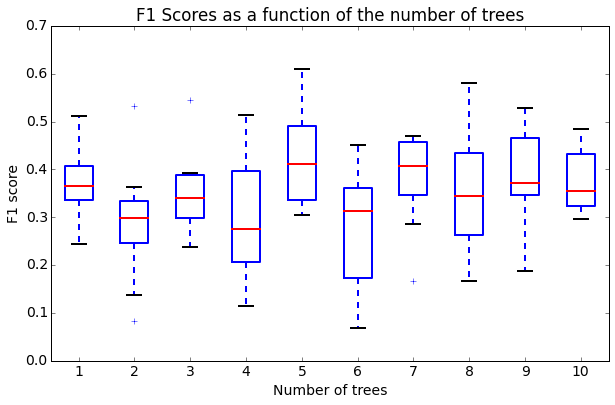

In [21]:
# repeat of previous but with F1 scoring instead
scores = []

for ne in range(1,11):
    clf = RandomForestClassifier(n_estimators = ne)
    score_list = cross_val_score(clf, X, Y, cv=10, scoring='f1')
    scores.append(score_list)

plt.boxplot(scores)
plt.xlabel('Number of trees')
plt.ylabel('F1 score')
plt.title('F1 Scores as a function of the number of trees')
plt.show()

**Conclusion:** Random Forest might not actually be good at classifying wine. 

## Visualizing Random Forest Models

Random forests allow us to compute a heuristic for determining how "important" a feature is in predicting a target. This heuristic measures the change in prediction accuracy if we take a given feature and permute (scramble) it across the datapoints in the training set. The more the accuracy drops when the feature is permuted, the more "important" we can conclude the feature is. Importance can be a useful way to select a small number of features for visualization.

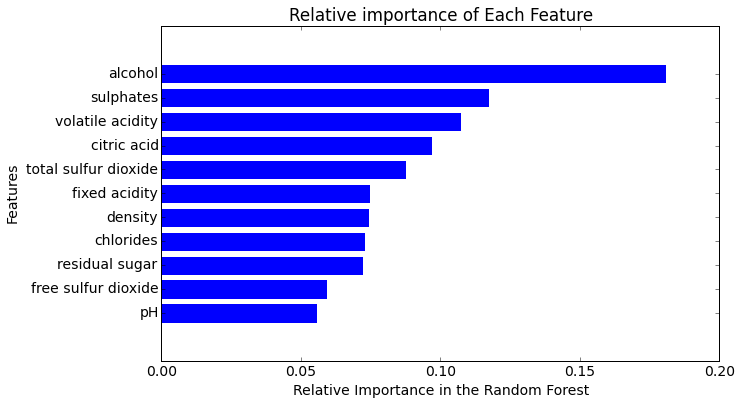

In [22]:
clf = RandomForestClassifier(n_estimators=15)

clf.fit(X,Y)
importance_list = clf.feature_importances_
name_list = df.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

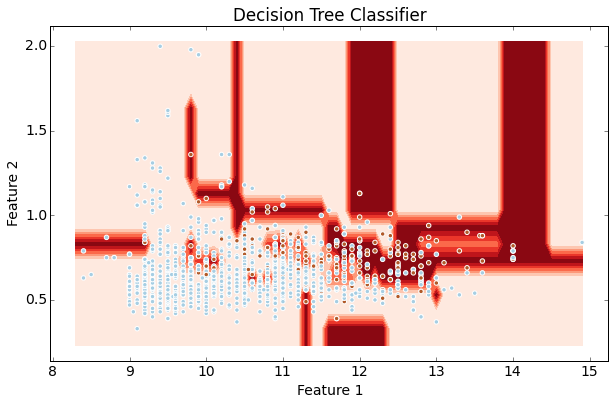

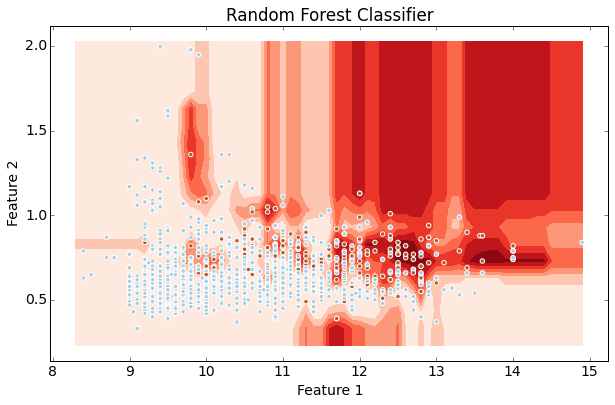

In [23]:
def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y,cmap=plt.cm.Paired)
    plt.show()
    
# your code here
imp_cols = clf.feature_importances_.argsort()[::-1][0:2]
X_imp = X[:,imp_cols]

classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier(n_estimators=15)]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier']
for c in xrange(2):
    plt.title(titleClassifer[c])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plot_decision_surface(classifiers[c], X_imp, Y)

This surface only uses the top two features selected by importance from the Random Forest classifier.  How could we include more features?

## ROC Curves

Example TBD...